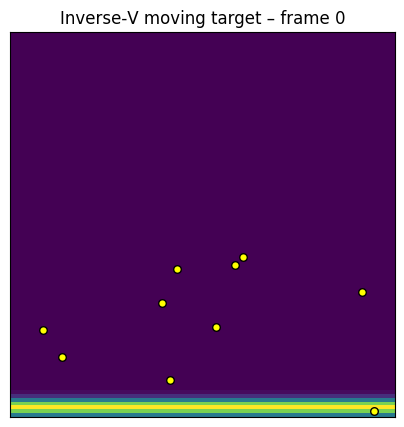

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML


# ---------- parameters ----------
grid_size = 100
num_agents = 10             # 1/4 of previous
steps = 180                 # frames
sigma = 1.2                 # vertical spread of the ridge
slope = 0.7                 # steepness of the inverse‑V arms
col_center = (grid_size - 1) / 2
USE_INVERSE_V = False            # ← flip this at will, or toggle mid-run

# ---------- helper: desired inverse‑V density at a given apex row ----------
def inverse_v_density(apex_row):
    """Return a grid_size×grid_size array whose ridge forms an inverse‑V
    with apex at (apex_row, col_center)."""
    rows = np.arange(grid_size)
    cols = np.arange(grid_size)
    R, C = np.meshgrid(rows, cols, indexing='ij')
    row_peak = apex_row - slope * np.abs(C - col_center)   # ridge equation
    dist = R - row_peak
    density = np.exp(-dist ** 2 / (2 * sigma ** 2))
    density[density < 1e-6] = 0     # tiny cut‑off
    density /= density.sum()
    return density

def horizontal_band_density(row_centre, width=5.5):
    """
    Returns a grid_size×grid_size array whose high-probability region
    is a horizontal stripe centred at `row_centre` (float), with Gaussian
    fall-off in the vertical direction and uniform weight along columns.
    """
    rows = np.arange(grid_size)
    band = np.exp(-(rows - row_centre) ** 2 / (2 * width ** 2))
    density = np.repeat(band[:, None], grid_size, axis=1)   # tile across columns
    density /= density.sum()
    return density


# initial desired density (apex low)
p_star = inverse_v_density(apex_row=2)

# ---------- initial agent positions (ONLY lower half) ----------
rows = np.random.randint(0, grid_size // 2, size=num_agents)   # 0 … 9  (if grid_size = 20)
cols = np.random.randint(0, grid_size,        size=num_agents) # 0 … 19
agent_pos = np.vstack([rows, cols]).T                          # shape (num_agents, 2)

moves = np.array([[0, 0], [-1, 0], [1, 0], [0, 1], [0, -1]])

def in_bounds(pos):
    return (pos[:, 0] >= 0) & (pos[:, 0] < grid_size) & (pos[:, 1] >= 0) & (pos[:, 1] < grid_size)

# ---------- matplotlib setup ----------
fig, ax = plt.subplots(figsize=(5, 5))
img = ax.imshow(p_star, origin='lower', interpolation='nearest', vmin=0, vmax=p_star.max())
scat = ax.scatter(agent_pos[:, 1], agent_pos[:, 0], s=30, c='yellow', edgecolor='k')
ax.set_xlim(-0.5, grid_size - 0.5)
ax.set_ylim(-0.5, grid_size - 0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Distrubuted control – frame 0")

# ---------- update per frame ----------
def update(frame):
    global agent_pos, p_star
    # --- move target upward ---
    if USE_INVERSE_V:
        apex_row  = 2 + frame * (grid_size - 4 - 2) / (steps - 1)
        p_star    = inverse_v_density(apex_row)
    else:
        band_row  = 2 + frame * (grid_size - 4 - 2) / (steps - 1)   # make the stripe glide upward
        p_star    = horizontal_band_density(band_row, width=1.5)
        flat_p_star = p_star.flatten()

    # empirical density
    counts = np.zeros((grid_size, grid_size), dtype=int)
    for r, c in agent_pos:
        counts[r, c] += 1
    p_hat = counts / num_agents
    flat_p_hat = p_hat.flatten()

    # move agents
    new_pos = agent_pos.copy()
    for idx, (r, c) in enumerate(agent_pos):
        candidates = agent_pos[idx] + moves
        mask = in_bounds(candidates.reshape(-1, 2))
        candidates = candidates[mask]

        # Markov row weights
        weights = []
        for cand in candidates:
            j = cand[0] * grid_size + cand[1]

            deficit = max(flat_p_star[j] - flat_p_hat[j], 0)
            ideal_occ = max(int(np.ceil(num_agents * flat_p_star[j])), 1)
            rho_j     = counts[cand[0], cand[1]] / ideal_occ
            gamma     = 4.0                       # tweak 1–3
            crowding  = 1.0 + rho_j**gamma        # >1  ⇒ penalty

            cost = np.linalg.norm(cand - agent_pos[idx], ord=1)

            w = deficit * np.exp(-cost) / crowding + 1e-6
            weights.append(w)

        weights = np.array(weights)
        weights /= weights.sum()
        choice = np.random.choice(len(candidates), p=weights)
        new_pos[idx] = candidates[choice]

    agent_pos = new_pos

    # update plot visuals
    img.set_data(p_star)
    simax = p_star.max()
    img.set_clim(vmin=0, vmax=simax)
    scat.set_offsets(np.c_[agent_pos[:, 1], agent_pos[:, 0]])
    ax.set_title(f"Inverse‑V moving target – frame {frame}")
    return img, scat

anim = FuncAnimation(fig, update, frames=steps, interval=120, blit=True)


In [16]:
HTML(anim.to_jshtml())          # renders the animation right in the notebook